In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import shutil

In [64]:
train_df = pd.read_csv('../monkey_cat_dog/train.csv')
train_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cats_001.jpg,474,266,cat,132,1,347,264
1,cats_002.jpg,474,474,cat,176,44,467,433
2,cats_003.jpg,474,314,cat,53,1,397,314
3,cats_004.jpg,474,355,cat,1,1,393,335
4,cats_005.jpg,474,316,cat,80,1,407,316
...,...,...,...,...,...,...,...,...
1304,monkey_groups_097.jpg,474,316,monkey,233,146,285,273
1305,monkey_groups_097.jpg,474,316,monkey,330,92,461,270
1306,monkey_groups_097.jpg,474,316,monkey,257,115,361,272
1307,monkey_groups_099.jpg,474,266,monkey,18,9,302,266


In [2]:
def get_imgarr_MonkeyCatDogDataset(sample):
    img_arr = cv2.imread(os.path.join('..', 'monkey_cat_dog', 'yolo-animal-detection-small', 'train', sample['filename']))
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]
    img_arr = cv2.rectangle(img_arr, (sample['xmin'], sample['ymin']), (sample['xmax'], sample['ymax']), color, 2)
    return img_arr

def get_imgarr_yoloInput(trash_img_path, trash_txt_path):
    trash_img = cv2.imread(trash_img_path)
    trash_img = cv2.cvtColor(trash_img, cv2.COLOR_BGR2RGB)
    with open(trash_txt_path) as f:
        contents = f.read()
    for line in contents.split("\n"):
        bbox = np.float32(line.split(" ")[1:])
        x_center, y_center, b_width, b_height = bbox[0]*trash_img.shape[1], bbox[1]*trash_img.shape[0], bbox[2]*trash_img.shape[1], bbox[3]*trash_img.shape[0]
        xmin, ymin, xmax, ymax = np.int32(np.round(x_center-b_width/2)), np.int32(np.round(y_center-b_height/2)), np.int32(np.round(x_center+b_width/2)), np.int32(np.round(y_center+b_height/2))
        color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]
        trash_img = cv2.rectangle(trash_img, (xmin, ymin), (xmax, ymax), color, 2)
    return trash_img

def get_imgarr_as_yoloInput(sample):
    xmin, ymin, xmax, ymax = sample['xmin'], sample['ymin'], sample['xmax'], sample['ymax']
    b_width, b_height = xmax-xmin, ymax-ymin
    x_center, y_center = xmin+b_width/2, ymin+b_height/2
    x_center, y_center, b_width, b_height = x_center/sample['width'], y_center/sample['height'], b_width/sample['width'], b_height/sample['height']
    return sample['class'], x_center, y_center, b_width, b_height

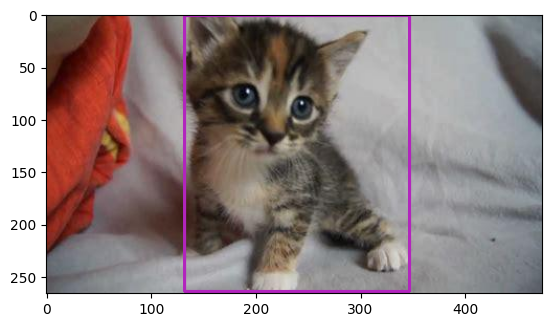

In [81]:
MCG_img = get_imgarr_MonkeyCatDogDataset(train_df.iloc[0])
plt.imshow(MCG_img)
plt.show()

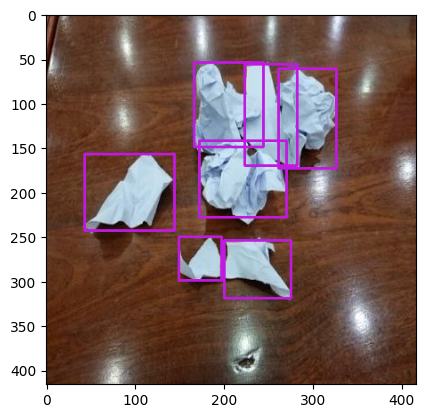

In [62]:
img_path = os.path.join('..', 'trash_or_not_dataset_fromRoboflow', 'train', 'images', '6_jpg.rf.651de0e97a1913a2a6498155d72b952f.jpg')
txt_path = os.path.join('..', 'trash_or_not_dataset_fromRoboflow', 'train', 'labels', '6_jpg.rf.651de0e97a1913a2a6498155d72b952f.txt')
trash_img = get_imgarr_yoloInput(img_path, txt_path)
plt.imshow(trash_img)
plt.show()

239.5 132.5 215 263
(266, 474, 3)
[0.50527424 0.4981203  0.4535865  0.9887218 ]
239.49998795986176 132.50000190734863 214.99999576807022 262.9999955892563
132 1 347 264


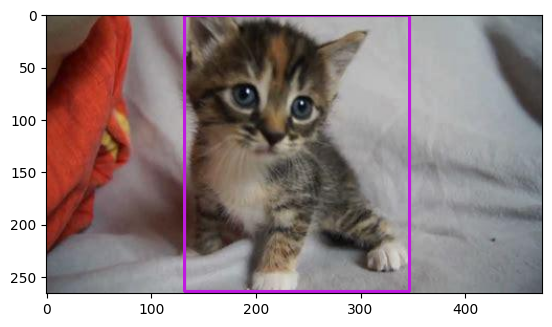

In [82]:
img_name = 'cats_001.jpg'
img_df = train_df[train_df['filename']==img_name]
lines = []
for _, s in img_df.iterrows():
    cl, x_center, y_center, b_width, b_height = get_imgarr_as_yoloInput(s)
    line = str(cl)+' '+str(x_center)+' '+str(y_center)+' '+str(b_width)+' '+str(b_height)
    lines.append(line)
with open('../prueba.txt', 'w') as f:
    f.writelines(lines)

img_path = os.path.join('..', 'monkey_cat_dog', 'yolo-animal-detection-small', 'train', 'cats_001.jpg')
txt_path = os.path.join('..', 'prueba.txt')
MCG_img_converted = get_imgarr_yoloInput(img_path, txt_path)
plt.imshow(MCG_img_converted)

In [9]:
def get_datasetFolder_as_yoloInput(p_df, task):
    cl_dict = {"monkey": 0, "cat": 1, "dog": 2}
    data_folder_path = os.path.join('..', 'monkey_cat_dog', 'yolo-animal-detection-small', task)
    img_filenames = p_df['filename'].unique()
    for img_name in img_filenames:
        img_df = p_df[p_df['filename']==img_name]
        lines = []
        for i, row in img_df.iterrows():
            src_file_path = os.path.join(data_folder_path, row['filename'])
            dst_file_path = os.path.join(task, 'images', row['filename'])
            print(i, row['filename'], src_file_path, dst_file_path)
            if not os.path.isfile(dst_file_path): shutil.copy(src_file_path, dst_file_path)
            _, x_center, y_center, b_width, b_height = get_imgarr_as_yoloInput(row)
            line = str(cl_dict[row['class']])+' '+str(x_center)+' '+str(y_center)+' '+str(b_width)+' '+str(b_height)+'\n'
            lines.append(line)
        print(lines)
        with open(os.path.join(task, 'labels', row['filename'].split(".")[0]+'.txt'), 'w') as f:
            f.writelines(lines)

In [10]:
train_df = pd.read_csv('../monkey_cat_dog/train.csv')
test_df = pd.read_csv('../monkey_cat_dog/test.csv')

get_datasetFolder_as_yoloInput(train_df, 'train')
get_datasetFolder_as_yoloInput(test_df, 'test')

0 cats_001.jpg ..\monkey_cat_dog\yolo-animal-detection-small\train\cats_001.jpg train\images\cats_001.jpg
['1 0.5052742616033755 0.4981203007518797 0.45358649789029537 0.9887218045112782\n']
1 cats_002.jpg ..\monkey_cat_dog\yolo-animal-detection-small\train\cats_002.jpg train\images\cats_002.jpg
['1 0.6782700421940928 0.5031645569620253 0.6139240506329114 0.820675105485232\n']
2 cats_003.jpg ..\monkey_cat_dog\yolo-animal-detection-small\train\cats_003.jpg train\images\cats_003.jpg
['1 0.47468354430379744 0.5015923566878981 0.7257383966244726 0.9968152866242038\n']
3 cats_004.jpg ..\monkey_cat_dog\yolo-animal-detection-small\train\cats_004.jpg train\images\cats_004.jpg
['1 0.41561181434599154 0.4732394366197183 0.8270042194092827 0.9408450704225352\n']
4 cats_005.jpg ..\monkey_cat_dog\yolo-animal-detection-small\train\cats_005.jpg train\images\cats_005.jpg
['1 0.5137130801687764 0.5015822784810127 0.689873417721519 0.9968354430379747\n']
5 cats_006.jpg ..\monkey_cat_dog\yolo-animal-dete